In [1]:
# Cell 1: Imports and Setup
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from pathlib import Path
import cv2
from collections import Counter

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

# Paths
PROJECT_ROOT = Path.cwd().parent
DATA_DIR = PROJECT_ROOT / "data" / "raw"


In [2]:
# Cell 2: Dataset Overview
print("="*60)
print("DATASET OVERVIEW")
print("="*60)

# Count files
image_extensions = ['*.jpg', '*.jpeg', '*.png', '*.JPG', '*.JPEG', '*.PNG']
all_images = []
for ext in image_extensions:
    all_images.extend(list(DATA_DIR.glob(f"**/{ext}")))

print(f"Total images found: {len(all_images)}")
print(f"Dataset location: {DATA_DIR}")

# Directory structure
print("\nDirectory structure:")
for item in DATA_DIR.rglob("*"):
    if item.is_dir():
        num_files = len(list(item.glob("*.*")))
        print(f"  {item.relative_to(DATA_DIR)}: {num_files} files")


DATASET OVERVIEW
Total images found: 112184
Dataset location: c:\Users\iiezu\Desktop\FYP2025\Hazard Loc v0.0\data\raw

Directory structure:
  Decks: 0 files
  Pavements: 0 files
  test: 0 files
  train: 0 files
  val: 0 files
  Walls: 0 files
  Decks\Cracked: 2025 files
  Decks\Non-cracked: 11595 files
  Pavements\Cracked: 2608 files
  Pavements\Non-cracked: 21726 files
  Walls\Cracked: 3851 files
  Walls\Non-cracked: 14287 files


In [3]:
# Cell 3: Sample Image Analysis
# Load first 5 images and check properties
sample_images = all_images[:5]

print("\nSample Image Properties:")
print("-"*60)

image_properties = []
for img_path in sample_images:
    img = Image.open(img_path)
    properties = {
        'filename': img_path.name,
        'size': img.size,
        'mode': img.mode,
        'format': img.format,
        'file_size_kb': img_path.stat().st_size / 1024
    }
    image_properties.append(properties)
    print(f"File: {properties['filename']}")
    print(f"  Size: {properties['size']}")
    print(f"  Mode: {properties['mode']}")
    print(f"  Format: {properties['format']}")
    print(f"  File size: {properties['file_size_kb']:.2f} KB\n")

# Create DataFrame
df_properties = pd.DataFrame(image_properties)



Sample Image Properties:
------------------------------------------------------------
File: 7001-115.jpg
  Size: (256, 256)
  Mode: RGB
  Format: JPEG
  File size: 9.53 KB

File: 7001-139.jpg
  Size: (256, 256)
  Mode: RGB
  Format: JPEG
  File size: 7.20 KB

File: 7001-151.jpg
  Size: (256, 256)
  Mode: RGB
  Format: JPEG
  File size: 8.13 KB

File: 7001-157.jpg
  Size: (256, 256)
  Mode: RGB
  Format: JPEG
  File size: 7.24 KB

File: 7001-169.jpg
  Size: (256, 256)
  Mode: RGB
  Format: JPEG
  File size: 7.42 KB



Image Size Distribution:
------------------------------------------------------------
Unique image sizes: 1

Most common sizes:
  (256, 256): 1000 images


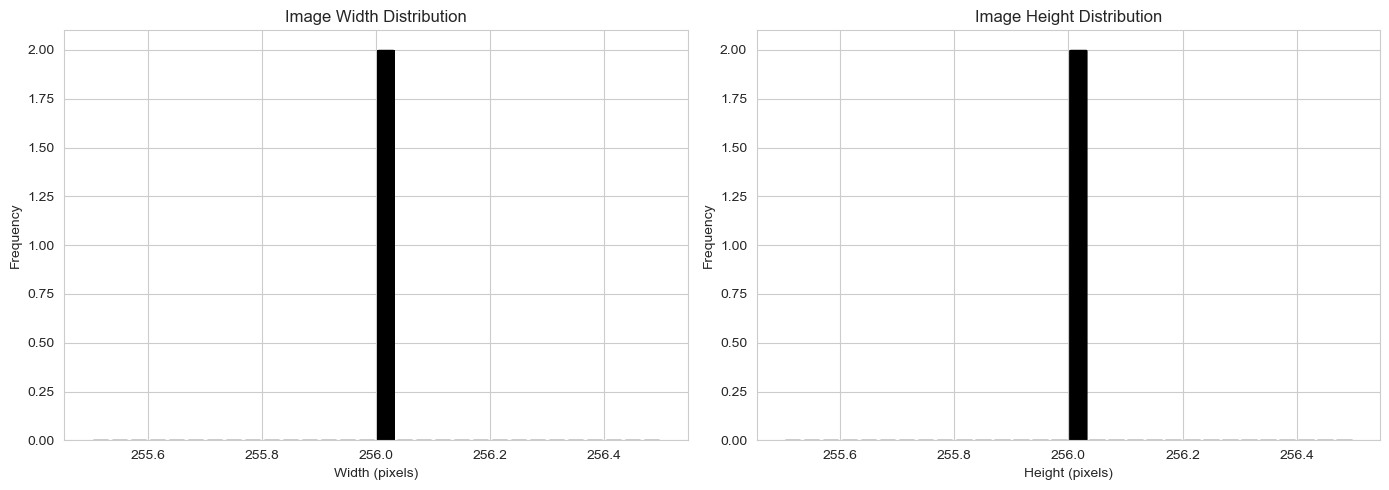

In [4]:
# Cell 4: Image Size Distribution
print("Image Size Distribution:")
print("-"*60)

sizes = []
for img_path in all_images[:1000]:  # Sample first 1000 for speed
    try:
        img = Image.open(img_path)
        sizes.append(img.size)
    except:
        pass

# Count unique sizes
size_counts = Counter(sizes)
print(f"Unique image sizes: {len(size_counts)}")
print("\nMost common sizes:")
for size, count in size_counts.most_common(5):
    print(f"  {size}: {count} images")

# Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

widths = [s for s in sizes]
heights = [s for s in sizes]

ax1.hist(widths, bins=30, edgecolor='black')
ax1.set_xlabel('Width (pixels)')
ax1.set_ylabel('Frequency')
ax1.set_title('Image Width Distribution')

ax2.hist(heights, bins=30, edgecolor='black')
ax2.set_xlabel('Height (pixels)')
ax2.set_ylabel('Frequency')
ax2.set_title('Image Height Distribution')

plt.tight_layout()
plt.show()



Class Distribution:
------------------------------------------------------------


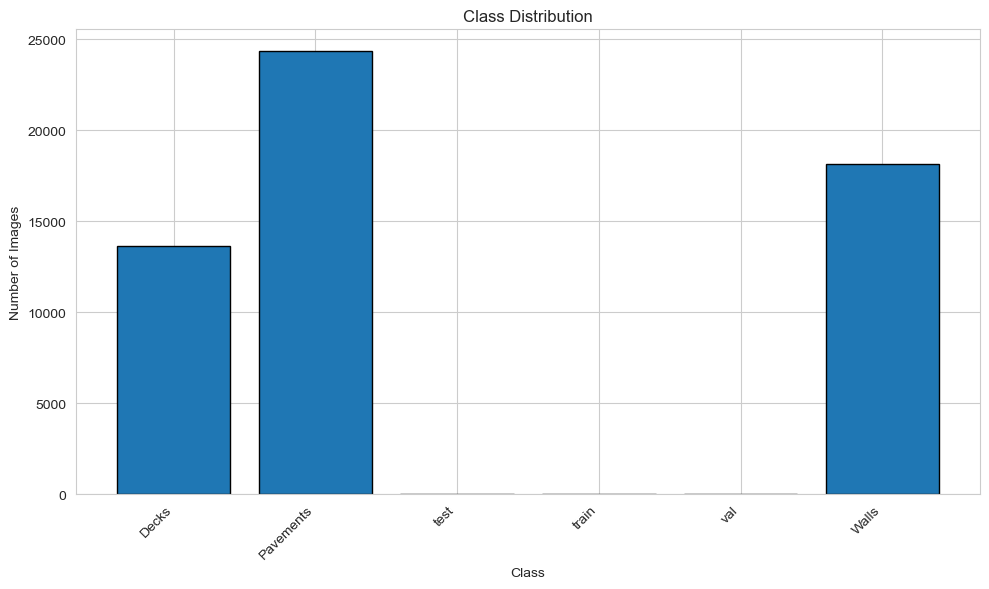


Class statistics:
  Decks: 13620 images
  Pavements: 24334 images
  test: 0 images
  train: 0 images
  val: 0 images
  Walls: 18138 images


In [5]:
# Cell 5: Class Distribution (if organized by folders)
print("\nClass Distribution:")
print("-"*60)

# Detect classes from folder structure
class_dirs = [d for d in DATA_DIR.iterdir() if d.is_dir()]

if class_dirs:
    class_counts = {}
    for class_dir in class_dirs:
        class_name = class_dir.name
        image_count = sum(1 for _ in class_dir.glob("**/*") 
                         if _.suffix.lower() in ['.jpg', '.jpeg', '.png'])
        class_counts[class_name] = image_count
    
    # Visualize
    plt.figure(figsize=(10, 6))
    plt.bar(class_counts.keys(), class_counts.values(), edgecolor='black')
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.title('Class Distribution')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    print("\nClass statistics:")
    for cls, count in class_counts.items():
        print(f"  {cls}: {count} images")
else:
    print("No class folders detected - manual organization needed")



Sample Images Visualization:


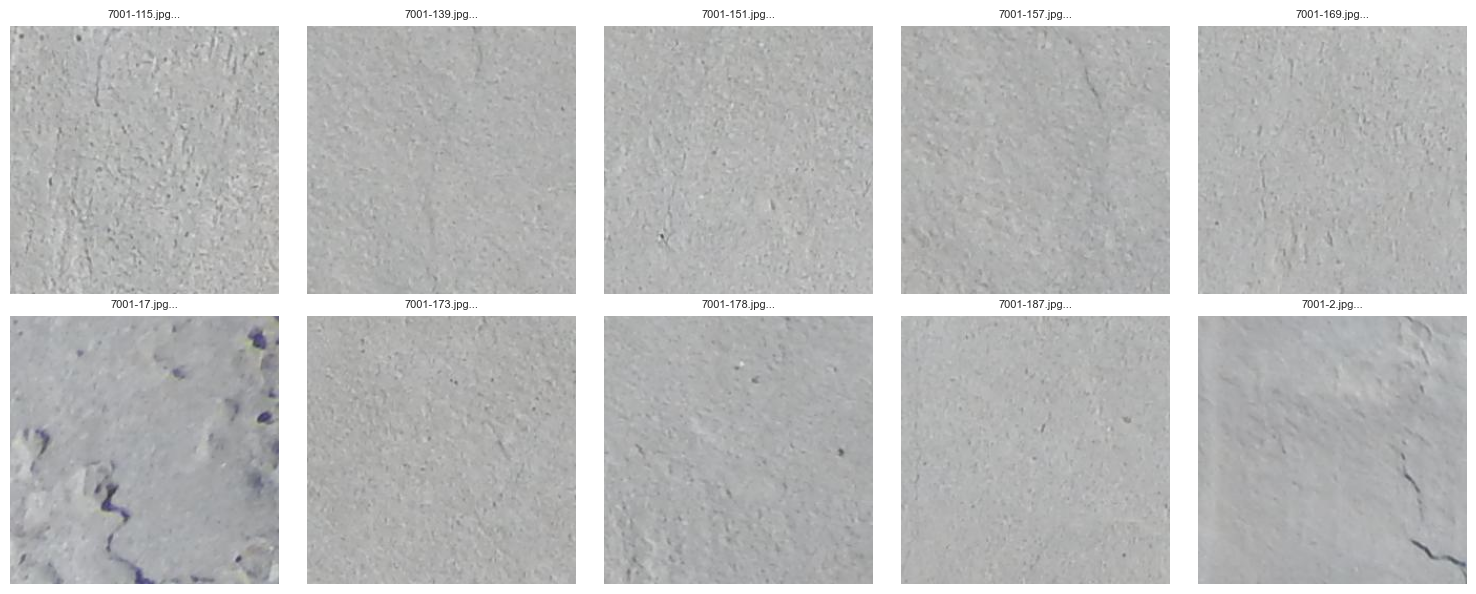

In [6]:
# Cell 6: Visualize Sample Images
print("\nSample Images Visualization:")

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

sample_imgs = all_images[:10]
for idx, img_path in enumerate(sample_imgs):
    img = Image.open(img_path)
    axes[idx].imshow(img)
    axes[idx].axis('off')
    axes[idx].set_title(f"{img_path.name[:15]}...", fontsize=8)

plt.tight_layout()
plt.show()



Color Channel Analysis (RGB):
------------------------------------------------------------


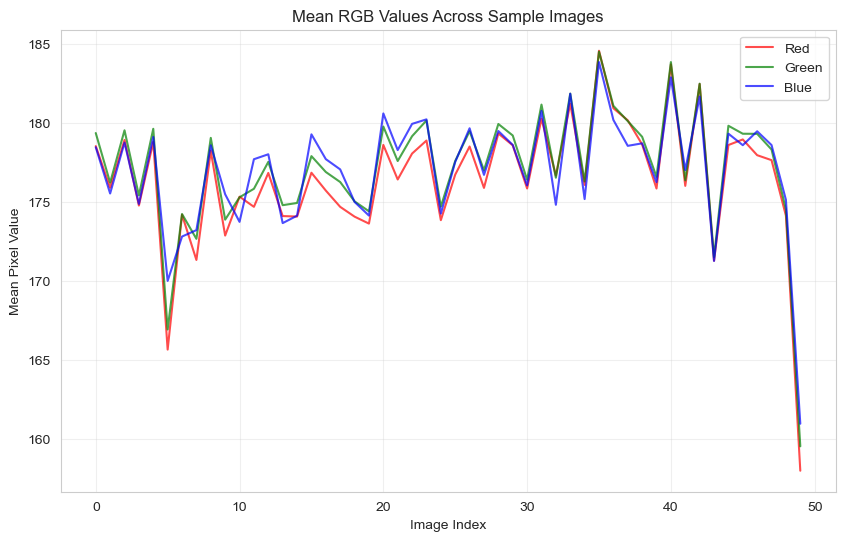


Average RGB values across 50 images:
  Red:   176.47
  Green: 177.19
  Blue:  177.08


In [7]:
# Cell 7: Color Channel Analysis
print("\nColor Channel Analysis (RGB):")
print("-"*60)

# Analyze first 50 images
sample_for_color = all_images[:50]
mean_rgb = []

for img_path in sample_for_color:
    img = np.array(Image.open(img_path))
    if len(img.shape) == 3:  # RGB image
        mean_rgb.append(img.mean(axis=(0,1)))

mean_rgb = np.array(mean_rgb)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(mean_rgb[:, 0], 'r-', label='Red', alpha=0.7)
plt.plot(mean_rgb[:, 1], 'g-', label='Green', alpha=0.7)
plt.plot(mean_rgb[:, 2], 'b-', label='Blue', alpha=0.7)
plt.xlabel('Image Index')
plt.ylabel('Mean Pixel Value')
plt.title('Mean RGB Values Across Sample Images')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"\nAverage RGB values across {len(mean_rgb)} images:")
print(f"  Red:   {mean_rgb[:, 0].mean():.2f}")
print(f"  Green: {mean_rgb[:, 1].mean():.2f}")
print(f"  Blue:  {mean_rgb[:, 2].mean():.2f}")


In [8]:
# Cell 8: Data Quality Check
print("\nData Quality Check:")
print("-"*60)

corrupted = []
unusual_format = []

for img_path in all_images[:1000]:  # Check first 1000
    try:
        img = Image.open(img_path)
        img.verify()  # Verify integrity
        
        # Check for unusual formats
        if img.mode not in ['RGB', 'L', 'RGBA']:
            unusual_format.append(str(img_path))
    except Exception as e:
        corrupted.append((str(img_path), str(e)))

print(f"Corrupted images: {len(corrupted)}")
print(f"Unusual formats: {len(unusual_format)}")

if corrupted:
    print("\nCorrupted files:")
    for path, error in corrupted[:5]:
        print(f"  {path}: {error}")



Data Quality Check:
------------------------------------------------------------
Corrupted images: 0
Unusual formats: 0


In [9]:
# Cell 9: Summary Statistics
print("\n" + "="*60)
print("DATASET SUMMARY")
print("="*60)

summary = {
    'Total Images': len(all_images),
    'Most Common Size': size_counts.most_common(1) if size_counts else 'N/A',
    'Average Width': np.mean([s for s in sizes]),
    'Average Height': np.mean([s for s in sizes]),
    'Corrupted Images': len(corrupted),
    'Unusual Formats': len(unusual_format)
}

for key, value in summary.items():
    print(f"{key}: {value}")

print("\n" + "="*60)
print("NEXT STEPS:")
print("="*60)
print("1. Verify class labels are correct")
print("2. Check if train/val/test split is needed")
print("3. Identify preprocessing requirements (resize, normalize)")
print("4. Plan data augmentation strategy")
print("5. Proceed to src/data/preprocess.py implementation")



DATASET SUMMARY
Total Images: 112184
Most Common Size: [((256, 256), 1000)]
Average Width: 256.0
Average Height: 256.0
Corrupted Images: 0
Unusual Formats: 0

NEXT STEPS:
1. Verify class labels are correct
2. Check if train/val/test split is needed
3. Identify preprocessing requirements (resize, normalize)
4. Plan data augmentation strategy
5. Proceed to src/data/preprocess.py implementation
